In [0]:
#@title Imports (RUN ME!) { display-mode: "form" }

# TODO: Swallow output
!pip -q install pydot_ng
!pip -q install graphviz
!apt install graphviz > /dev/null

from __future__ import absolute_import, division, print_function

import io
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython import display
from google.colab import files
import matplotlib.pyplot as plt
from keras.models import Sequential
import tensorflow.contrib.eager as tfe
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

try:
  tf.enable_eager_execution()
  print('Running in Eager mode.')
except ValueError:
  print('Already running in Eager mode')

In [0]:
import io
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython import display
from google.colab import files
import matplotlib.pyplot as plt
from keras.models import Sequential
import tensorflow.contrib.eager as tfe
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline


# 0 Helper Functions

In [0]:
from sklearn.metrics import roc_curve, auc
# Plot confusion matrix
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()    
    

    
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
    
    
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

    
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32) 
      
      
  

# 1 Binary Classification

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

## 1.1 Data [Titanic - Kaggle]

In [104]:
uploaded = files.upload()

Saving Titanic_data.csv to Titanic_data.csv


In [105]:
titanic = pd.read_csv(io.StringIO(uploaded['Titanic_data.csv'].decode('utf-8')))
titanic.head()

,Pclass,Age,SibSp,Parch,Fare,male,C,Q,S,Survived
0,3,22,1.0,0,7,1,0,0,1,0
1,1,38,1.0,0,71,0,1,0,0,1
2,3,26,0.0,0,8,0,0,0,1,1
3,1,35,1.0,0,53,0,0,0,1,1
4,3,35,0.0,0,8,1,0,0,1,0


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


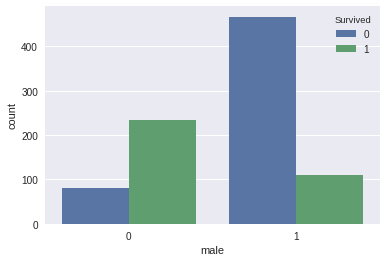

In [106]:
sns.countplot(x='male', data=titanic, hue='Survived')


In [0]:
# Split data to training and testing
scaler = StandardScaler()
X = titanic.drop(['Survived', 'SibSp'], axis=1) # Select features to train on
y = titanic.Survived                 # Select the target 
#X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


In [108]:
X.shape # Return the number of observations as well as the number of columns

(890, 8)

In [109]:
y.shape

(890,)

In [110]:
X.shape[1] # Return  the number of columns only

8

## 1.2 Build the Classifier

In [0]:


model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [112]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 64)                576       
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 65        
Total para

In [0]:
nb_epochs = 500
hist = model.fit(X_train, y_train, epochs= nb_epochs, batch_size=128, verbose=0)
#score = model.evaluate(x_test, y_test, batch_size=128

In [0]:
train_loss = hist.history['loss']
train_acc = hist.history['acc']
xc = range(nb_epochs)

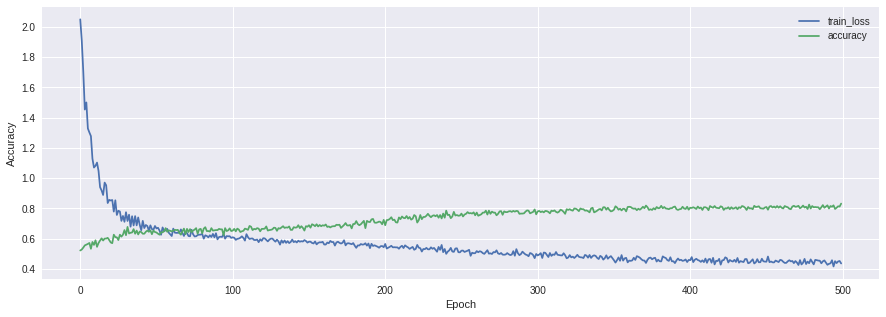

In [115]:
plt.figure(1, figsize = (15,5))
plt.plot(xc, train_loss)
plt.plot(xc, train_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(['train_loss', 'accuracy'])

In [0]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
# y_test2 = np.argmax(y_test,axis=1)

In [0]:
cm = confusion_matrix(y_test, pred)

Confusion matrix, without normalization
[[159   0]
 [108   0]]


Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


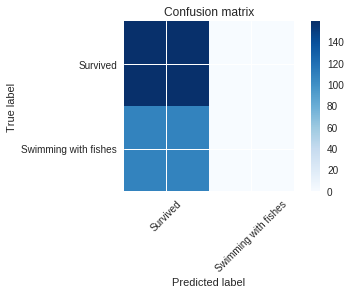

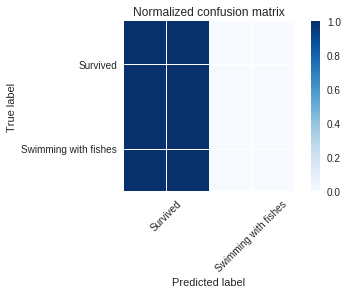

In [121]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
#y_test2 = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
names = ['Survived', 'Swimming with fishes']
cm = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, names)
print ('\n')
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, names,title='Normalized confusion matrix')

plt.show()

# 2 MultiClass Classification

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

## 2.1 Data [Iris Dataset]

In [0]:
from sklearn import datasets
from keras.utils import to_categorical
iris = datasets.load_iris()

In [0]:
X = iris.data
y = to_categorical(iris.target, 3)

In [126]:
feature_names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width']
X = pd.DataFrame(X, columns = feature_names)
X.head()

,sepal-length,sepal-width,petal-length,petal-width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [0]:

model = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:

model.add(Dense(64, activation='relu', input_dim=X.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [129]:
model.fit(X_train, y_train, epochs=20, batch_size=128)
score = model.evaluate(X_test, y_test, batch_size=128)

Epoch 1/20
105/105 [==============================] - 1s 13ms/step - loss: 1.7147 - acc: 0.3143
Epoch 2/20
105/105 [==============================] - 0s 74us/step - loss: 1.6632 - acc: 0.2952
Epoch 3/20
105/105 [==============================] - 0s 45us/step - loss: 1.6972 - acc: 0.2857
Epoch 4/20
105/105 [==============================] - 0s 29us/step - loss: 1.5819 - acc: 0.3333
Epoch 5/20
105/105 [==============================] - 0s 41us/step - loss: 1.3356 - acc: 0.3524
Epoch 6/20
105/105 [==============================] - 0s 36us/step - loss: 1.3253 - acc: 0.3810
Epoch 7/20
105/105 [==============================] - 0s 43us/step - loss: 1.5179 - acc: 0.3810
Epoch 8/20
105/105 [==============================] - 0s 51us/step - loss: 1.2497 - acc: 0.4571
Epoch 9/20
105/105 [==============================] - 0s 52us/step - loss: 1.4290 - acc: 0.3048
Epoch 10/20
105/105 [==============================] - 0s 42us/step - loss: 1.4728 - acc: 0.3429
Epoch 11/20
105/105 [==================

Confusion matrix, without normalization
[[19  0  0]
 [ 0  6  7]
 [ 0  0 13]]


Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.46 0.54]
 [0.   0.   1.  ]]


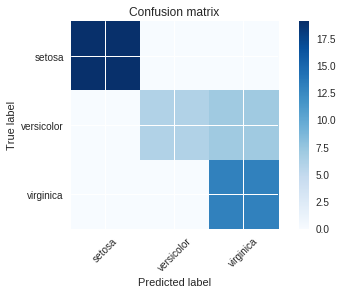

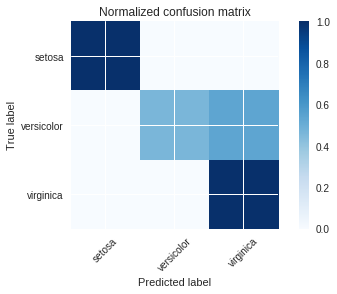

In [67]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test2 = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
names = ['setosa', 'versicolor', 'virginica']
cm = confusion_matrix(y_test2, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, names)
print ('\n')
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, names,title='Normalized confusion matrix')

plt.show()

# 3 Image Classification

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

## 3.1 Data [CIFAR10 Dataset]

* Consists of 50,000 training images 
* 10,000 test images

In [79]:
cifar = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170500096/170498071 [==============================] - 16s 0us/step


In [0]:
# Take the last 10000 images from the training set to form a validation set 
train_labels = train_labels.squeeze()
validation_images = train_images[-10000:, :, :]
validation_labels = train_labels[-10000:]
train_images = train_images[:-10000, :, :]
train_labels = train_labels[:-10000]

In [81]:
print('train_images.shape = {}, data-type = {}'.format(train_images.shape, train_images.dtype))
print('train_labels.shape = {}, data-type = {}'.format(train_labels.shape, train_labels.dtype))

print('validation_images.shape = {}, data-type = {}'.format(validation_images.shape, validation_images.dtype))
print('validation_labels.shape = {}, data-type = {}'.format(validation_labels.shape, validation_labels.dtype))

train_images.shape = (40000, 32, 32, 3), data-type = uint8
train_labels.shape = (40000,), data-type = uint8
validation_images.shape = (10000, 32, 32, 3), data-type = uint8
validation_labels.shape = (10000,), data-type = uint8


### 3.1.1 visualize Examples

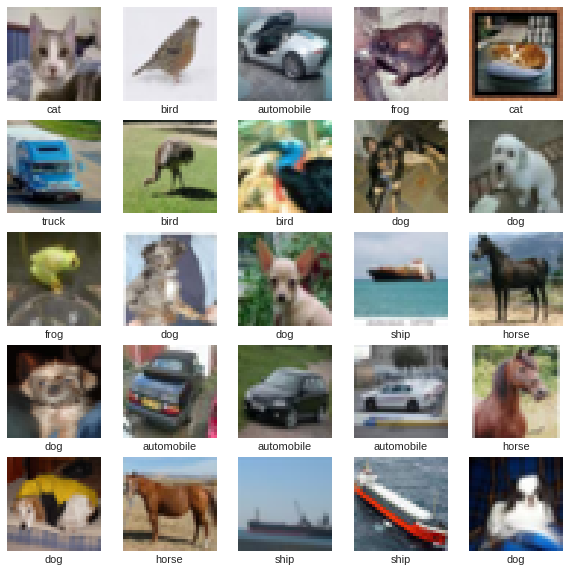

In [82]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  img_index = np.random.randint(0, 40000)
  plt.imshow(train_images[img_index])
  plt.xlabel(cifar_labels[train_labels[img_index]])

## 3.2 Computer Vision - A Convolutional Network Classifier¶

Finally, we build a simple convolutional architecture to classify the CIFAR images. We will build a mini version of the AlexNet architecture, which consists of 5 convolutional layers with max-pooling, followed by 3 fully-connected layers at the end. In order to investigate the effect each of these two layers have on the number of parameters, we'll build the model in two stages.

First, the convolutional layers + max-pooling:

In [0]:

# Define the convolutinal part of the model architecture using Keras Layers.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 48)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 128)       55424     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 192)         221376    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 192)         331968    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 128)         221312    
__________

Now we add a fully-connected part. Note that we also add "Dropout" after the first fully-connected layer. Dropout is a regularization technique which randomly zeros out ("drops") connections between neurons, and it was one of the key innovations of the AlexNet paper in 2012.

In [0]:
model.add(tf.keras.layers.Flatten())  # Flatten "squeezes" a 3-D volume down into a single vector.
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

## 3.3  Train the Conv Classifier

In [0]:
batch_size = 12
num_epochs = 1  # The number of epochs (full passes through the data) to train for

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# The fit function allows you to fit the compiled model to some training data
hist = model.fit(x=train_images, 
          y=train_labels, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')

Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 245s 6ms/step - loss: 1.4810 - acc: 0.4749 - val_loss: 1.4177 - val_acc: 0.4881
Training complete


## 3.4 Test Performance of the Classifier

In [0]:
metric_values = model.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

10000/10000 [==============================] - 12s 1ms/step
Final TEST performance
loss: 1.6346234086990357
acc: 0.3852


# 4 Regression

In [0]:
from sklearn import metrics
from scipy.stats import zscore
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

## 4.1 Data 

In [37]:
uploaded = files.upload()

Saving auto-mpg.csv to auto-mpg (1).csv


In [69]:
df = pd.read_csv(io.StringIO(uploaded['auto-mpg.csv'].decode('utf-8')))
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [0]:
# create feature vector
preprocess = False
missing_median(df, 'horsepower')
encode_text_dummy(df, 'origin')
df.drop('name',1,inplace=True)
if preprocess:
    encode_numeric_zscore(df, 'horsepower')
    encode_numeric_zscore(df, 'weight')
    encode_numeric_zscore(df, 'cylinders')
    encode_numeric_zscore(df, 'displacement')
    encode_numeric_zscore(df, 'acceleration')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

## 4.2 Build the 3 Layer Network

In [0]:
model = Sequential()
model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
#checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model


In [72]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)

Epoch 00382: early stopping


In [73]:
# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))



Score (RMSE): 6.637089252471924


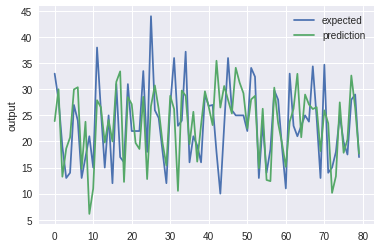

In [75]:
chart_regression(pred.flatten(),y_test,sort=False)

# 5 Saving Models

## 5.1 Saving the Model

* To use same model in the future
* To share the model

In [0]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

## 5.2 Saving Weights


In [0]:
# Save now
model.save_weights('left_overs_model_weights.h5')

# Load to use later/share
left_overs = model.load_weights('left_overs_model_weights.h5')

## 5.3 Use Pre-Trained Models

How can I use pre-trained models in Keras?
Code and pre-trained weights are available for the following image classification models:

* Xception
* VGG16
* VGG19
* ResNet50
* Inception v3
* Inception-ResNet v2
* MobileNet v1

They can be imported from the module keras.applications:

In [0]:
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet

model = Xception(weights='imagenet', include_top=True)

In [102]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________